In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger, TensorBoard

In [2]:
%%bash
mkdir ~/.kaggle
cp kaggle.json ~/.kaggle/
chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d balraj98/cvcclinicdb

 99% 130M/131M [00:07<00:00, 23.6MB/s]
100% 131M/131M [00:07<00:00, 19.3MB/s]


In [ ]:
!unzip /content/cvcclinicdb.zip -d /content/cvcclinic_data/

In [5]:
DATASET_PATH: str = "/content/cvcclinic_data"
ORIGINAL_IMAGES: str = os.path.join(DATASET_PATH, "PNG/Original")
MASK_IMAGES: str = os.path.join(DATASET_PATH, "PNG/Ground Truth")


BATCH: int = 8
EPOCHS: int = 50
IMG_HEIGHT: int = 256
IMG_WIDTH: int = 256

lr: float = 1e-4

In [6]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    
    return inputs, labels

In [7]:
def load_data(split: int = 0.1):

    images = sorted(glob(ORIGINAL_IMAGES + "/*.png"))
    masks = sorted(glob(MASK_IMAGES + "/*.png"))

    total_size: int = len(images)
    valid_size: int = int(split * total_size)
    test_size: int = int(split * total_size)

    train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)


def read_image(path):
    path = path.decode()

    img = cv2.imread(path, cv2.IMREAD_COLOR)

    # resize the image
    img = cv2.resize(img, (256, 256))

    # normalize
    img = img / 255.0
    return img

def read_mask(path):
    path = path.decode()

    mask_img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    # resize the image
    mask_img = cv2.resize(mask_img, (256, 256))

    # normalize
    mask_img = mask_img / 255.0

    mask_img = np.expand_dims(mask_img, axis=-1)
    
    return mask_img


def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])

    x.set_shape([256, 256, 3])
    y.set_shape([256, 256, 1])

    return x, y


# to create tensorflow dataset
def tf_dataset(x, y, batch: int = 8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset

In [8]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data()

train_dataset = tf_dataset(train_x, train_y, batch=BATCH).map(Augment()).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_dataset = tf_dataset(valid_x, valid_y, batch=BATCH)

In [9]:
def display(display_list):
  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

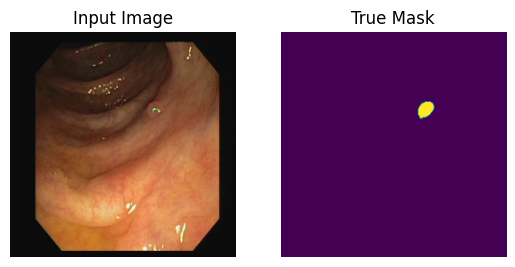

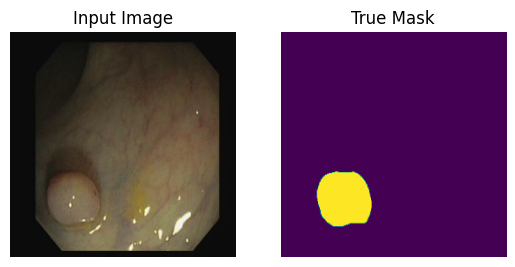

In [10]:
for images, masks in train_dataset.take(2):
    sample_image, sample_mask = images[0], masks[0]

    # Convert BGR to RGB
    sample_image = sample_image[:, :, ::-1]
    
    display([sample_image, sample_mask])

In [11]:
def conv_block(x, num_filters):
    x = Conv2D(num_filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x


def build_model():
    size: int = 256
    num_filters: list[int] = [16, 32, 48, 64]

    inputs = Input((size, size, 3))

    skip_x = []
    x = inputs

    # Encoder
    for f in num_filters:
        x = conv_block(x, f)
        skip_x.append(x)
        x = MaxPool2D((2, 2))(x)

    # Bridge
    x = conv_block(x, num_filters[-1])

    num_filters.reverse()
    skip_x.reverse()

    # Decoder
    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2))(x)
        xs = skip_x[i]
        x = Concatenate()([x, xs])
        x = conv_block(x, f)
    
    # output
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)

    return Model(inputs, x)

In [12]:
model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [13]:
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

In [14]:
# optimizer
opt = tf.keras.optimizers.Adam(lr)

# metrices
metrics = ["acc", tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), iou]

# compile the model
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=metrics)

# callbacks
callbacks = [
    ModelCheckpoint("files/model.h5"),
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=4),
    CSVLogger("files/data.csv"),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]


train_steps = len(train_x) // BATCH
valid_steps = len(valid_x) // BATCH

if len(train_x) % BATCH != 0:
    train_steps += 1

if len(valid_x) % BATCH != 0:
    valid_steps += 1

In [15]:
history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)

Epoch 1/50
62/62 [==============================] - 32s 129ms/step - loss: 0.4724 - acc: 0.8282 - recall: 0.4411 - precision: 0.2656 - iou: 0.1220 - val_loss: 0.5725 - val_acc: 0.9124 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_iou: 0.0760 - lr: 1.0000e-04
Epoch 2/50
62/62 [==============================] - 7s 109ms/step - loss: 0.3317 - acc: 0.9128 - recall: 0.3357 - precision: 0.5836 - iou: 0.1490 - val_loss: 0.4254 - val_acc: 0.9124 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_iou: 0.0699 - lr: 1.0000e-04
Epoch 3/50
62/62 [==============================] - 6s 93ms/step - loss: 0.2825 - acc: 0.9241 - recall: 0.3786 - precision: 0.6984 - iou: 0.1717 - val_loss: 0.3363 - val_acc: 0.9124 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_iou: 0.0722 - lr: 1.0000e-04
Epoch 4/50
62/62 [==============================] - 8s 134ms/step - loss: 0.2538 - acc: 0.9298 - recall: 0.4456 - precision: 0.7241 - iou: 0.1934 - val_loss: 0.3032 - val_acc: 0.9121 - va

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

iou = history.history['iou']
val_iou = history.history['val_iou']
recall = history.history['recall']
val_recall = history.history['val_recall']
precision = history.history['precision']
val_precision = history.history['val_precision']

## Plot Metrices

In [39]:
def save_and_show_fig(metric: str, train, val):
    plt.figure(figsize=(12, 10))
    plt.plot(range(len(train)), train, 'bo-', label=f'Training {metric}')
    plt.plot(range(len(val)), val, 'ro-', label=f'Validation {metric}')
    plt.xlabel('Epoch')
    plt.ylabel(f'{metric}')
    plt.title(f'Training and Validation {metric}')
    plt.legend()

    # Set integer ticks on the x-axis
    plt.xticks(range(len(train)), range(len(train)))

    plt.savefig(f"{metric}.png", format="png", dpi=300)
    plt.show()

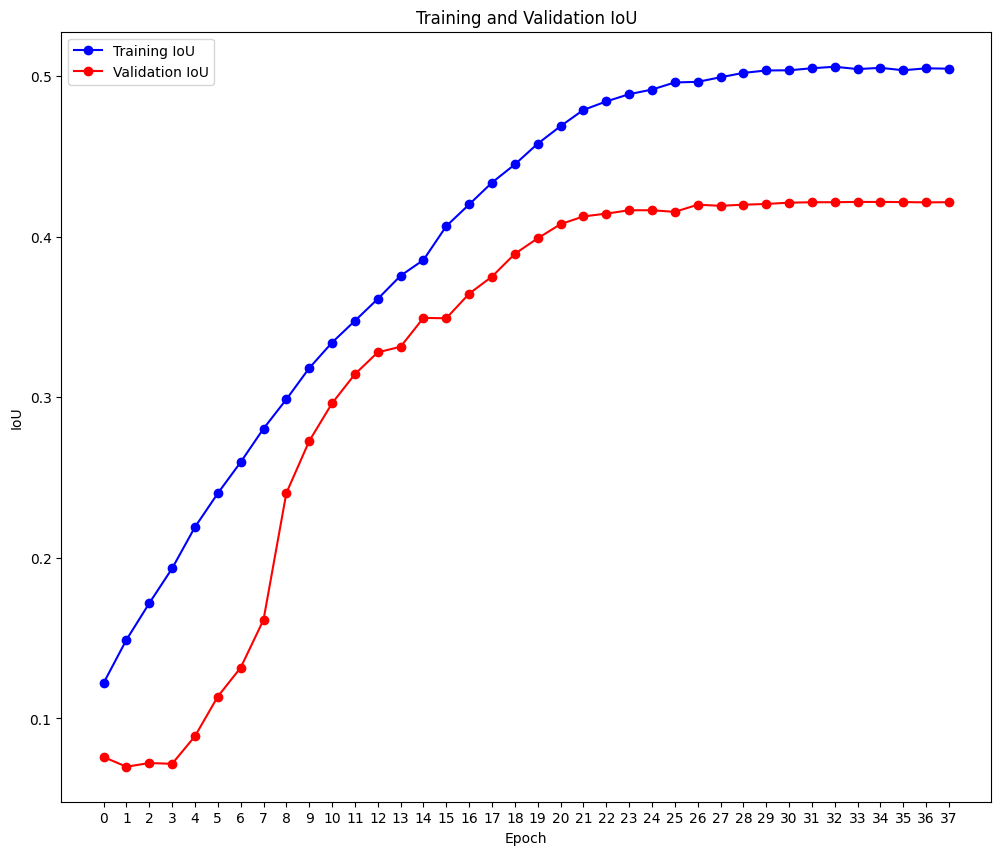

In [40]:
save_and_show_fig("IoU", iou, val_iou)

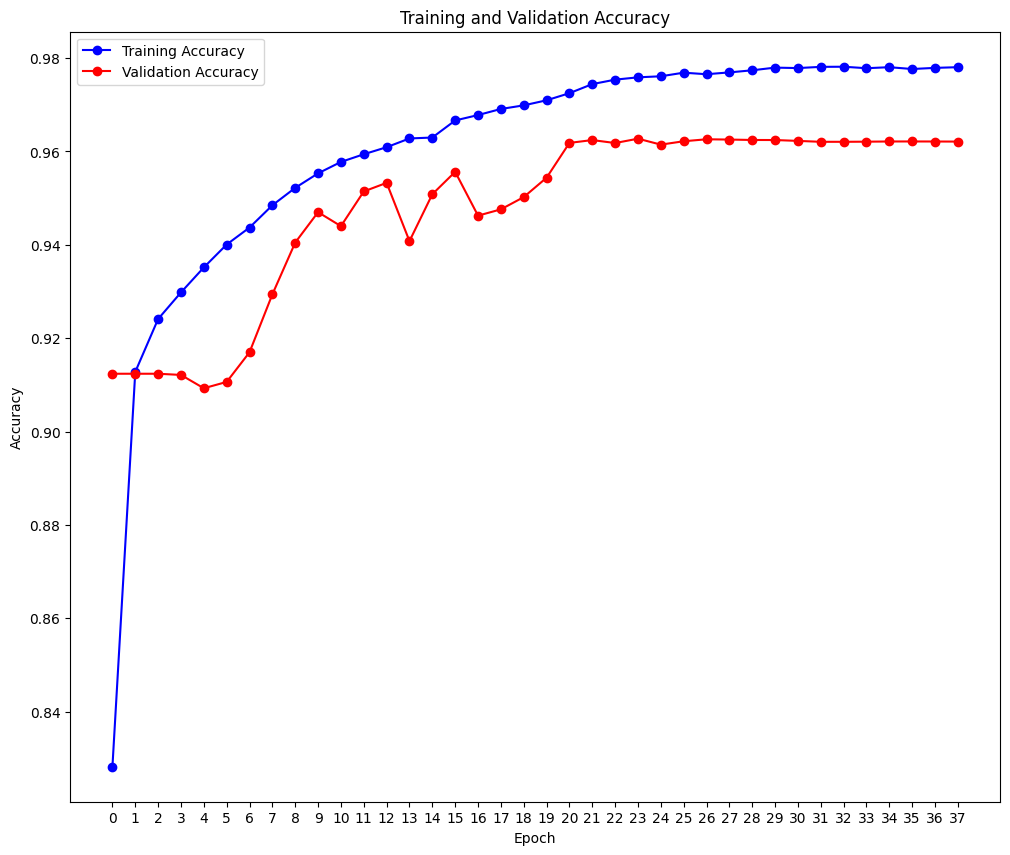

In [41]:
save_and_show_fig("Accuracy", acc, val_acc)

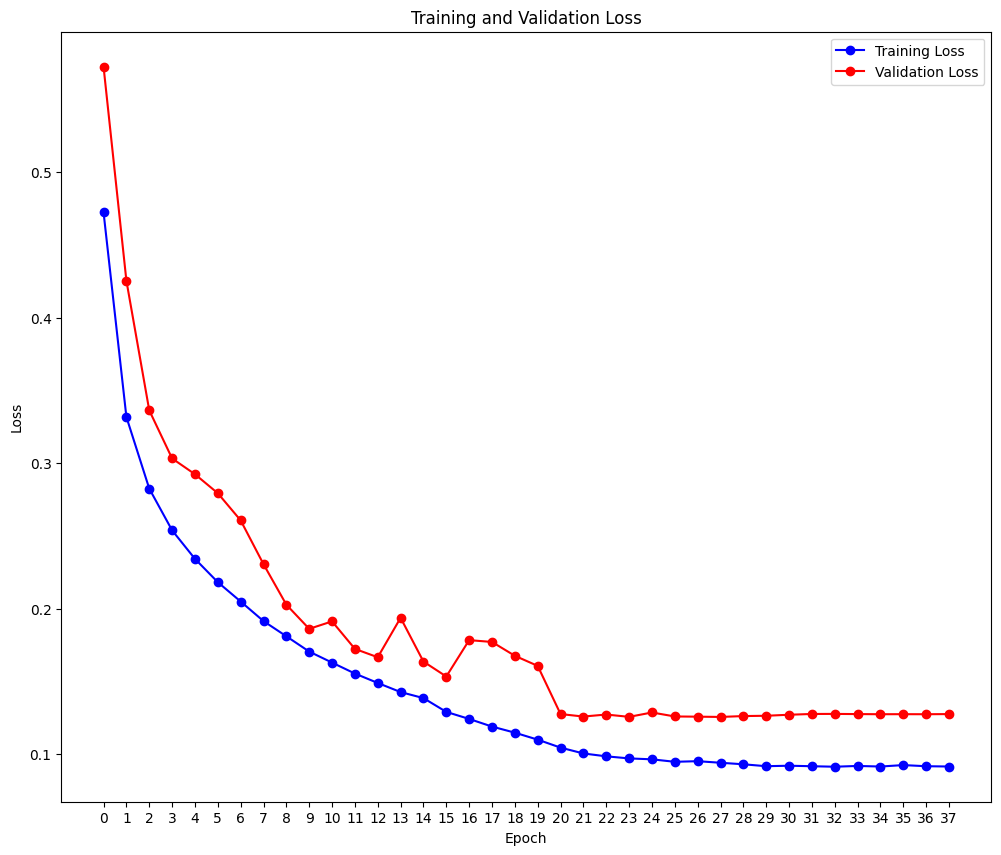

In [42]:
save_and_show_fig("Loss", loss, val_loss)

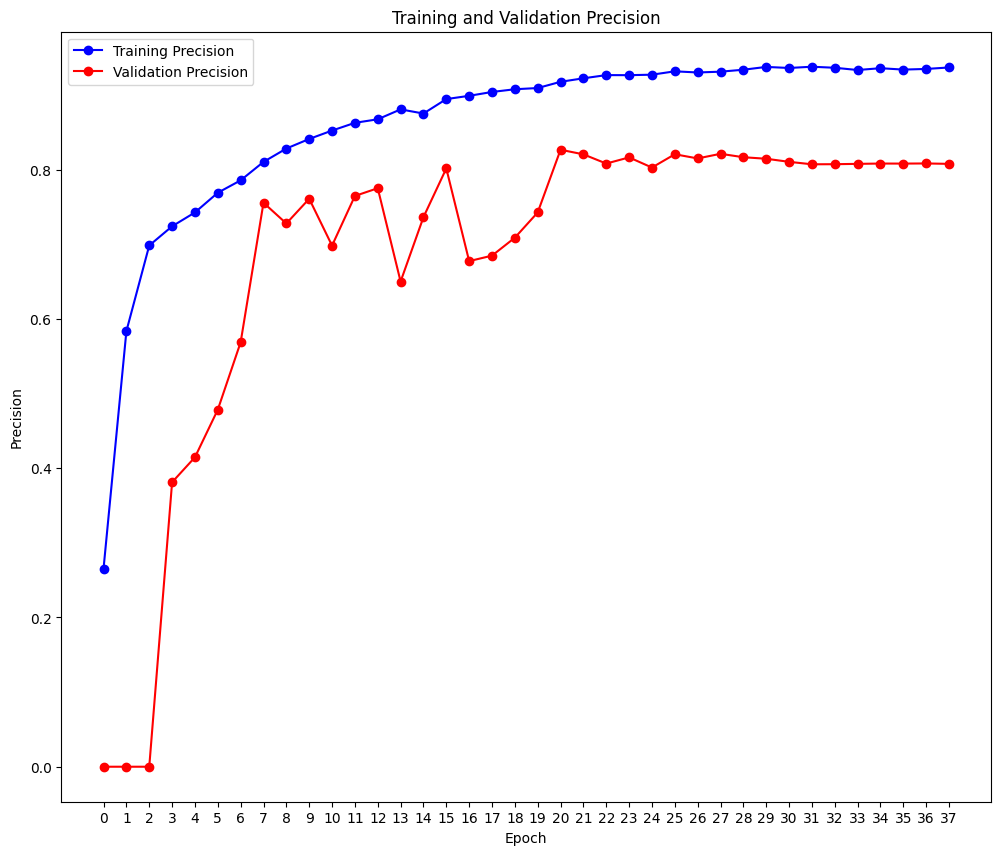

In [43]:
save_and_show_fig("Precision", precision, val_precision)

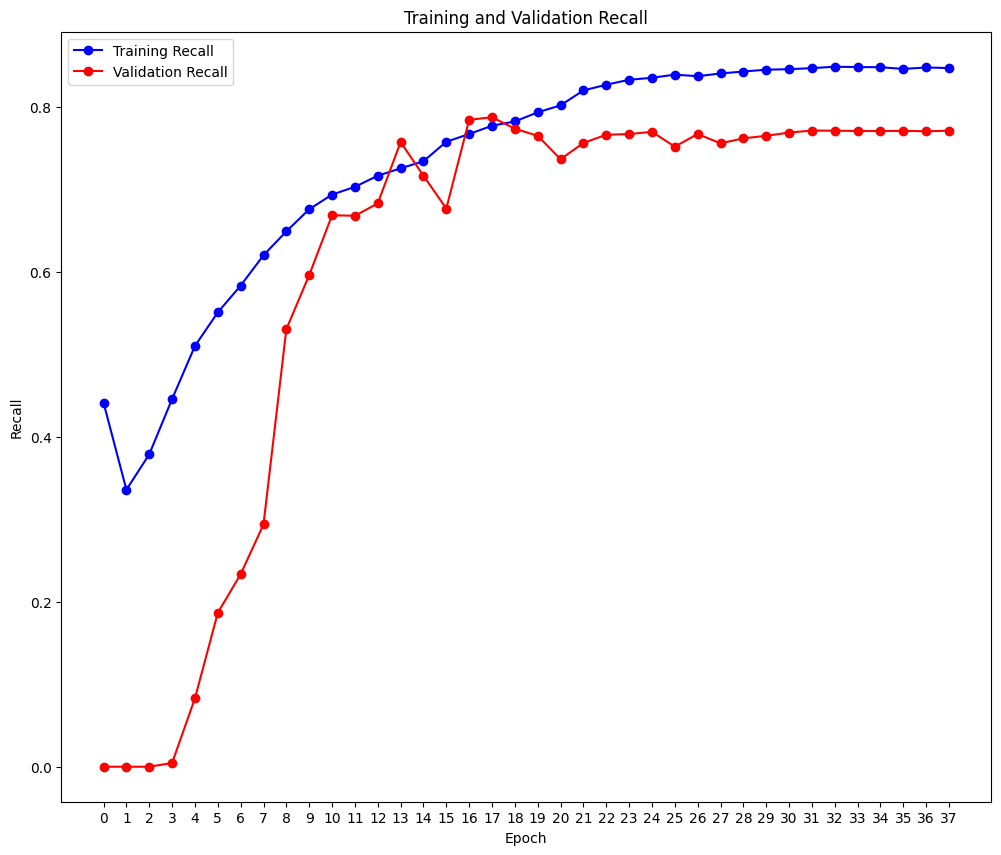

In [44]:
save_and_show_fig("Recall", recall, val_recall)

In [24]:
test_dataset = tf_dataset(test_x, test_y, batch=1)
test_steps = len(test_x) // 1

if len(test_x) % 1 != 0:
    test_steps += 1

model.evaluate(test_dataset, steps=test_steps)

61/61 [==============================] - 1s 10ms/step - loss: 0.1346 - acc: 0.9591 - recall: 0.7552 - precision: 0.8295 - iou: 0.3627


[0.13456562161445618,
 0.9590616822242737,
 0.7551704049110413,
 0.8295074105262756,
 0.3627009093761444]

In [25]:
def pred_read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (256, 256))
    x = x / 255.0
    return x

def pred_read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (256, 256))
    x = np.expand_dims(x, axis=-1)
    return x

def pred_mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

In [26]:
# Takes an input image and returns the predicted image
def get_predict_image(test_image_path: str):

    # read and preprocess the image
    x = pred_read_image(test_image_path)

    # predict using model
    pred_img = model.predict(np.expand_dims(x, axis=0))[0] > 0.5

    # doing some extra operations
    pred_img = pred_mask_parse(pred_img) * 255.0

    return pred_img

1/1 [==============================] - 1s 707ms/step


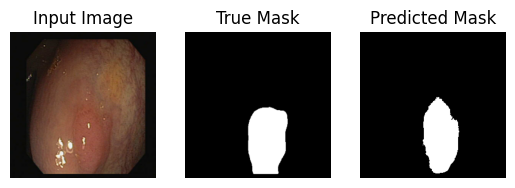

1/1 [==============================] - 0s 34ms/step


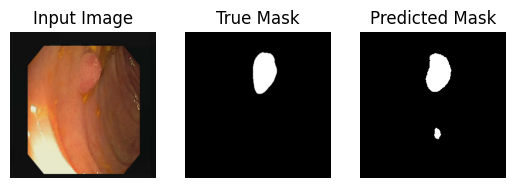

1/1 [==============================] - 0s 34ms/step


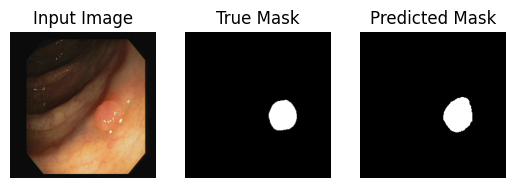

1/1 [==============================] - 0s 138ms/step


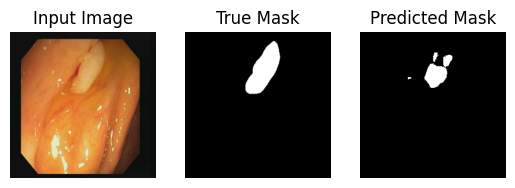

1/1 [==============================] - 0s 34ms/step


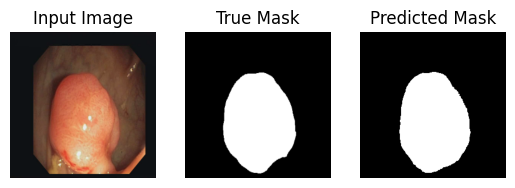

In [27]:
def show_predictions(num=1):
    rand_values = np.random.choice(np.arange(len(test_x)), size=num, replace=False)
    for i in rand_values:
        
        # input test image
        x = pred_read_image(test_x[i]) * 255.0

        # Convert BGR to RGB
        x = x[:, :, ::-1]
        
        # original segmentation
        y = pred_read_mask(test_y[i])
        y = pred_mask_parse(y)

        pred_mask = get_predict_image(test_x[i])

        display([x, y, pred_mask])

show_predictions(5)

In [ ]:
folder_path = "results"

# Creatint a folder called "results"
if not os.path.exists(os.path.join(os.getcwd(), folder_path)):
    os.makedirs(folder_path)
    print("Folder created successfully!")
else:
    print("Folder already exists.")

for i, (x, y) in enumerate(zip(test_x, test_y)):
    # input test image
    x = pred_read_image(x)
    
    # original segmentation
    y = pred_read_mask(y)

    # predict each test images
    y_pred = model.predict(np.expand_dims(x, axis=0))[0] > 0.5

    # height and width of the images
    h, w, _ = x.shape

    # a white line
    white_line = np.ones((h, 10, 3)) * 255.0

    # list of three images with white lines as separator
    all_images = [
        x * 255.0, white_line,
        pred_mask_parse(y), white_line,
        pred_mask_parse(y_pred) * 255.0
    ]

    # combine three images
    image = np.concatenate(all_images, axis=1)

    # write all the combines images into result folder
    cv2.imwrite(f"{folder_path}/{i}.png", image)

In [53]:
import shutil

# Specify the folder path you want to download
folder_path = '/content/results/'

# Specify the destination zip file path
zip_file_path = '/content/results'

# Create a zip file of the folder
shutil.make_archive(zip_file_path, 'zip', folder_path)

'/content/test_masks.zip'

In [45]:
import zipfile

# List the image file paths
image_files = [
    '/content/Accuracy.png', 
    '/content/IoU.png', 
    '/content/Loss.png', 
    '/content/Precision.png', 
    '/content/Recall.png'
]

file_name: str = "images.zip"

# Create a zip file
with zipfile.ZipFile(file_name, 'w') as zipf:
    # Add each image file to the zip
    for file in image_files:
        zipf.write(file)

# Verify if the zip file is created
if os.path.exists(file_name):
    print("Zip file created successfully!")
else:
    print("Failed to create the zip file.")

Zip file created successfully!
